Cooling coffee cup or Divergent of temperature field of some defined volume is negative

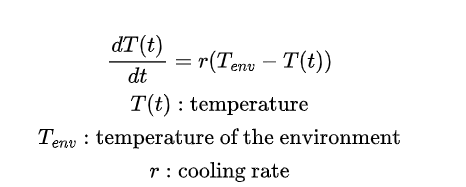

Coffe was cooling over time of 15 min and Envirement temperature was 25 C and cooling rate was of 0.005

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import functools
import random

torch.manual_seed(42)
np.random.seed(10)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Parameters
T_env = 25      # environment temperature (°C)
T0 = 100         # initial temperature (°C)
r = 0.005        # cooling rate (1/s)
times = np.linspace(0, 1000, 1000)  # time range (s)


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

eq = functools.partial(cooling_law, Tenv=T_env, T0=T0, R=r)


In [ ]:
# Now instead of randomly choosing points we take firs 10 points from first 300 points recorded of the sequence
# Training data
N=10
t=np.linspace(0,300,N)
T=eq(t)+8*np.random.randn(N)

In [ ]:
# # Investigation of shufling the data
# perm = np.random.permutation(len(t))

# # Apply the same permutation to both arrays
# t = t[perm]
# T = T[perm]

In [6]:
# Investigation of random sampling of the data
# t = np.random.uniform(0, 300, N)
# T=eq(t)+2*np.random.randn(N)

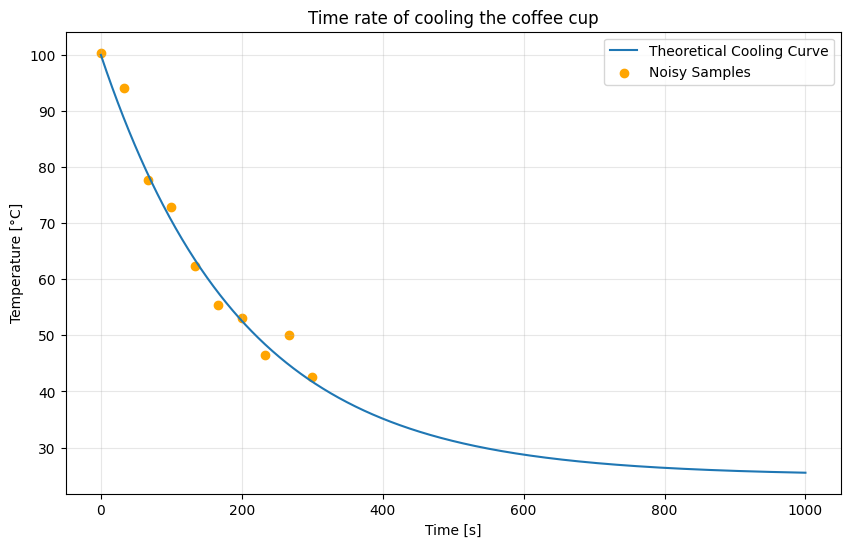

In [17]:
plt.figure(figsize=(10,6))
plt.plot(times,eq(times),label='Theoretical Cooling Curve')
plt.scatter(t, T, color='orange', label='Noisy Samples')
plt.grid(alpha=0.3)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Time rate of cooling the coffee cup')
plt.legend()

In [8]:
# Our networks
def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(device).reshape(n_samples, -1)

class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100, # number of neurons per hidden layer
        epochs=1000, # number of training epochs
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


Epoch 0/20000, loss: 4713.88
Epoch 2000/20000, loss: 2510.27
Epoch 4000/20000, loss: 2142.91
Epoch 6000/20000, loss: 725.67
Epoch 8000/20000, loss: 88.45
Epoch 10000/20000, loss: 2.00
Epoch 12000/20000, loss: 0.74
Epoch 14000/20000, loss: 0.34
Epoch 16000/20000, loss: 0.32
Epoch 18000/20000, loss: 0.30


Text(0, 0.5, 'Loss')

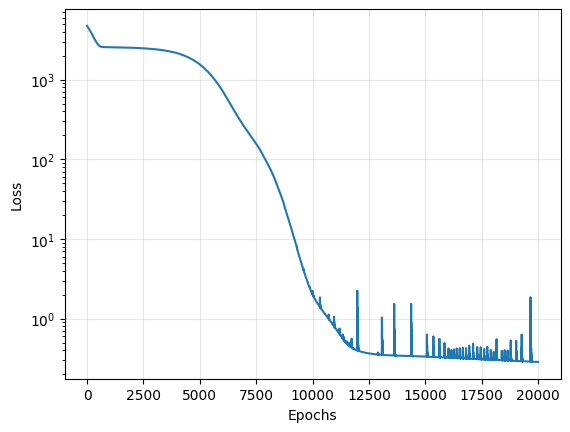

In [9]:
net=Net(1,1,loss2=None,epochs=20000,lr=1e-5).to(device)
losses=net.fit(t,T)

plt.plot(losses)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')

Epoch 0/20000, loss: 11219.99
Epoch 2000/20000, loss: 3920.28
Epoch 4000/20000, loss: 2428.07
Epoch 6000/20000, loss: 1601.73
Epoch 8000/20000, loss: 1195.74
Epoch 10000/20000, loss: 1008.17
Epoch 12000/20000, loss: 918.12
Epoch 14000/20000, loss: 854.08
Epoch 16000/20000, loss: 791.12
Epoch 18000/20000, loss: 731.09


Text(0, 0.5, 'Loss')

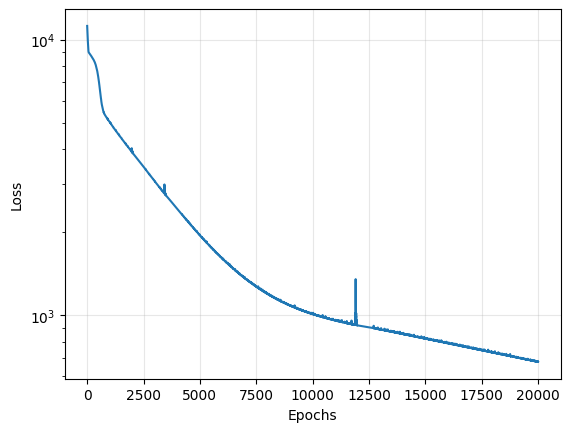

In [10]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))


netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(device)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')

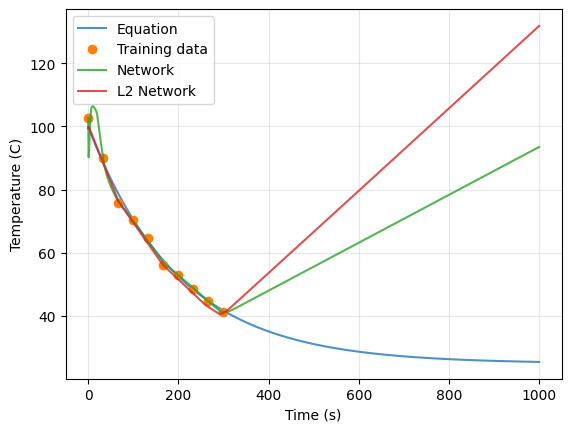

In [11]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, eq(times), alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')
plt.grid(alpha=0.3)

Incorporating Physic loss

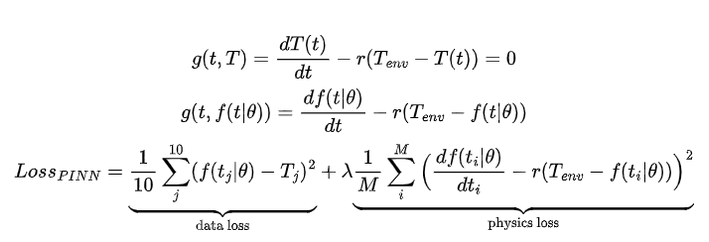

In [12]:

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )



def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(device)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = r*(T_env - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4917.87
Epoch 3000/30000, loss: 2409.37
Epoch 6000/30000, loss: 514.52
Epoch 9000/30000, loss: 5.24
Epoch 12000/30000, loss: 3.76
Epoch 15000/30000, loss: 3.29
Epoch 18000/30000, loss: 3.01
Epoch 21000/30000, loss: 2.88
Epoch 24000/30000, loss: 2.81
Epoch 27000/30000, loss: 2.80


Text(0, 0.5, 'Loss')

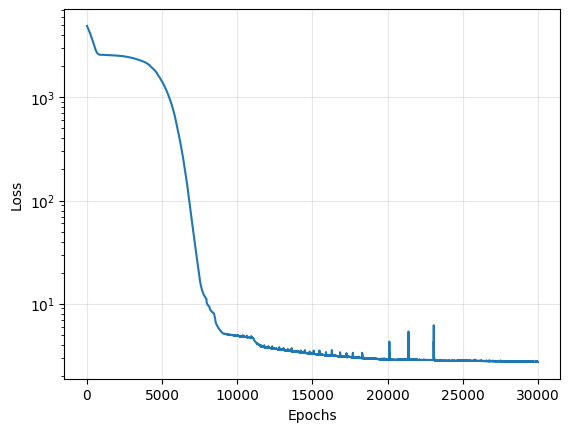

In [18]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(device)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')

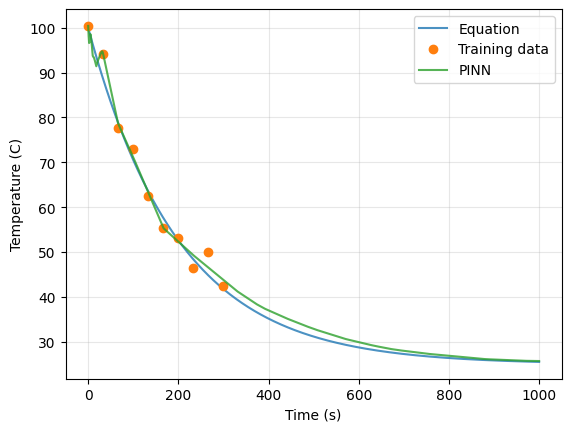

In [19]:
preds = net.predict(times)

plt.plot(times, eq(times), alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')
plt.grid(alpha=0.3)